In [1]:
import torch
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [2]:
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
# dataset class
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        return label, image_values, target
        
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')

In [3]:
mnist_dataset = MnistDataset('c:/data/data/mnist_train.csv')

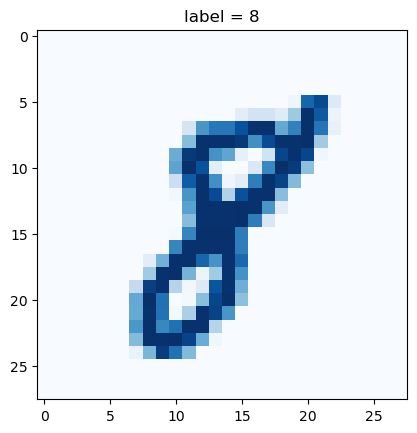

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

mnist_dataset.plot_image(17)

In [5]:
# 랜덤 이미지 생성 함수(real)
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

# 랜덤 이미지 생성 함수(fake)
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [6]:
# 판별모형
import torch.nn as nn
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 200),
            # 음수이면 기울기 0.02
            nn.LeakyReLU(0.02),
            # 레이어에 대한 정규화
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # binary cross entropy
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs.to(DEVICE))

        loss = self.loss_function(outputs, targets.to(DEVICE))
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [7]:
D = Discriminator().to(DEVICE)
for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


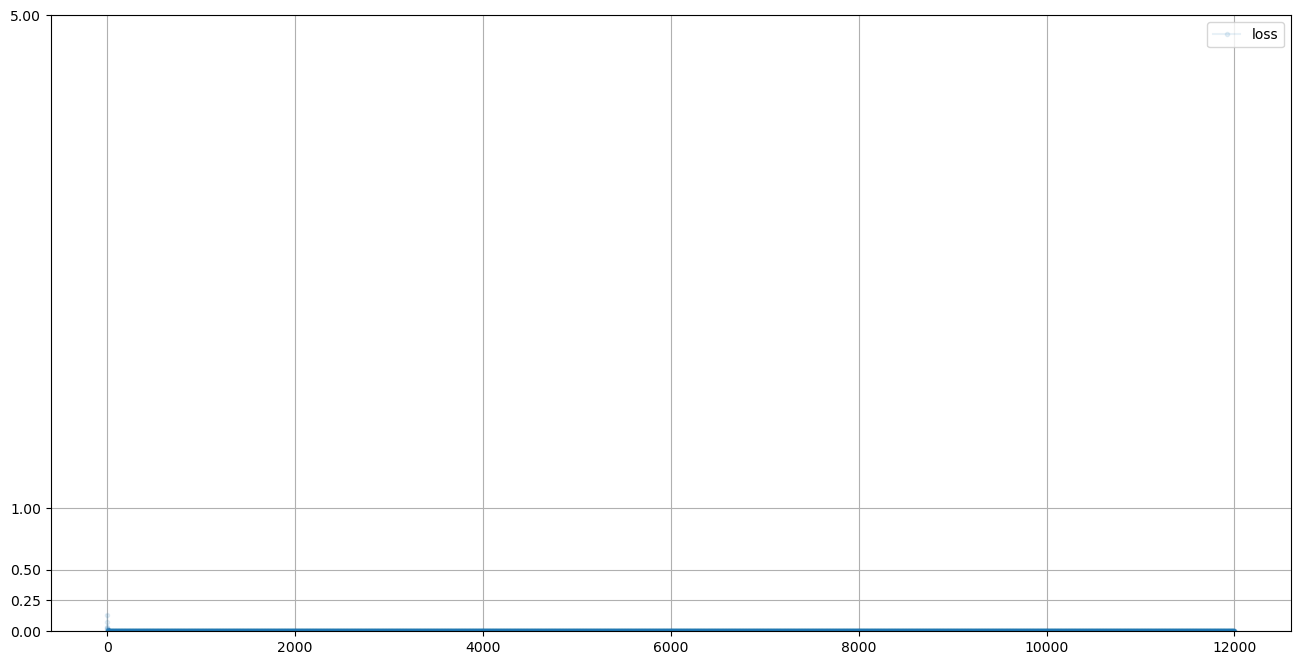

In [8]:
D.plot_progress()

In [9]:
import random
# test real data
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
    print( D.forward( image_data_tensor.to(DEVICE) ).item() )

# test fake data
for i in range(4):
    print( D.forward( generate_random_image(784).to(DEVICE) ).item() )

1.0
1.0
1.0
1.0
9.184308695509014e-12
9.68889551922203e-12
8.677701786308223e-12
8.507863684392714e-12


In [10]:
# 생성모델
class Generator(nn.Module):
 
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs.to(DEVICE))
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs.to(DEVICE))
        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets.to(DEVICE))
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

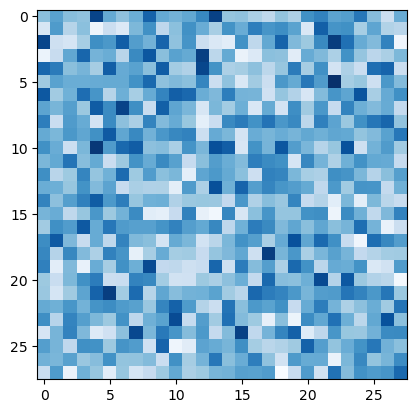

In [11]:
G = Generator().to(DEVICE)
output = G.forward(generate_random_seed(100))
img = output.cpu().detach().numpy().reshape(28,28)
plt.imshow(img, cmap='Blues')
plt.show()

In [12]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
epochs = 4
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 판별모형 훈련(true)
        D.train(image_data_tensor, torch.FloatTensor([1.0]))

        # 판별모형 훈련(false)
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
        
        # 생성모형 훈련
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
D.plot_progress() # 판독오차

In [ ]:
G.plot_progress() # 생성오차

In [ ]:
torch.save(G,'final_G.h5')

In [ ]:
print(G.model[3].weight[0][:10])
print(G.model[3].bias[:10])